In [1]:
num_weeks = 15

## VENTAS

In [2]:
import xmlrpc.client
from datetime import date, timedelta, datetime
import pandas as pd

# Conexión con Odoo (manteniendo tus credenciales)
username = "juan.cano@donsson.com"  # tu usuario
password = "1000285668"         # tu contraseña
url = "https://donsson.com"     # URL del servidor
db = "Donsson_produccion" # nombre de la base de datos


# --- Autenticación ---
common = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/common")
uid = common.authenticate(db, username, password, {})
models = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/object")

# --- Fechas ---
weeks = num_weeks

# --- Fechas automáticas ---
hoy = date.today()
fecha_fin = hoy.strftime("%Y-%m-%d")
fecha_inicio = (hoy - timedelta(weeks=weeks)).strftime("%Y-%m-%d")

# --- 1) Buscar facturas válidas (account.invoice) ---

invoice_domain = [
    ("date_invoice", ">=", fecha_inicio),
    ("date_invoice", "<=", fecha_fin),
    ("type", "=", "out_invoice"),    # solo ventas
    ("state", "in", ["open", "paid"])
]

invoice_ids = models.execute_kw(
    db, uid, password,
    "account.invoice", "search",
    [invoice_domain]
)
print(f"Facturas encontradas: {len(invoice_ids)}")

# --- 2) Descargar las líneas de esas facturas (account.invoice.line) ---

# Campos de la LÍNEA de factura. Eliminamos 'number', 'user_id', 'section_id', 'partner_id' porque irán en la factura.
line_fields = ["product_id", "quantity", "price_subtotal", "invoice_id","create_date","origin"] 

records = []
limit = 20000
offset = 0

while True:
    result = models.execute_kw(
        db, uid, password,
        "account.invoice.line", "search_read",
        [[("invoice_id", "in", invoice_ids)]],
        {"fields": line_fields, "limit": limit, "offset": offset}
    )
    if not result:
        break
    records.extend(result)
    offset += limit
    print(f"Descargados {len(records)} registros de líneas...")

# --- 3) Pasar a DataFrame de líneas ---
line_df = pd.DataFrame(records).fillna(0)


# Separar product_id
line_df["product_id_num"] = line_df["product_id"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else None
)
line_df["product_name"] = line_df["product_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else str(x)
)

# Separar invoice_id
line_df["invoice_id_num"] = line_df["invoice_id"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else None
)
line_df["invoice_name"] = line_df["invoice_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else str(x)
)

# Convertir fecha a datetime
line_df["date_invoice"] = pd.to_datetime(line_df["create_date"], errors="coerce")

# Eliminar las columnas originales problemáticas
line_df = line_df.drop(columns=["product_id", "invoice_id","create_date"])

print(f"Total de líneas descargadas: {len(line_df)}")

# ----------------------------------------------------
# --- 4) Descargar los campos adicionales de Factura (account.invoice) ---
# ----------------------------------------------------
# Añadimos los campos que quieres: number, user_id, section_id, y también partner_id y store_id
invoice_fields = ["id", "store_id", "number", "user_id", "section_id", "partner_id"]
invoices = models.execute_kw(
    db, uid, password,
    "account.invoice", "read",
    [invoice_ids], # Solo las facturas que encontramos
    {"fields": invoice_fields}
)
invoice_df = pd.DataFrame(invoices)

# --- 5) Procesar campos de la factura ---

# Separar store_id
invoice_df["store_name"] = invoice_df["store_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else str(x)
)

# Separar user_id (Vendedor)
invoice_df["salesperson_name"] = invoice_df["user_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else None
)

# Separar section_id (Equipo de Ventas)
invoice_df["sales_team_name"] = invoice_df["section_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else None
)

# Separar partner_id (Cliente/Partner)
invoice_df["partner_id_num"] = invoice_df["partner_id"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else None
)
# El nombre del partner es el segundo elemento de la tupla (si existe)
invoice_df["client_name_inv"] = invoice_df["partner_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else None
)


# Eliminar columnas originales no deseadas o ya procesadas
invoice_df = invoice_df.drop(columns=["store_id", "user_id", "section_id", "partner_id"])


# ----------------------------------------------------
# --- 6) Fusionar DataFrames ---
# ----------------------------------------------------

# Fusionamos las líneas de factura (line_df) con los datos de las facturas (invoice_df)
df = line_df.merge(
    invoice_df, 
    left_on="invoice_id_num", 
    right_on="id", 
    how="left"
)

# Limpieza final de columnas de IDs de factura
df = df.drop(columns=["invoice_id_num", "product_id_num"])


df['origin'] = df['origin'].astype('string')

# 2 minutos 15 semanas

Facturas encontradas: 15764
Descargados 20000 registros de líneas...
Descargados 40000 registros de líneas...
Descargados 60000 registros de líneas...
Descargados 61438 registros de líneas...
Total de líneas descargadas: 61438


In [3]:
df.head()

,origin,price_subtotal,id_x,quantity,product_name,invoice_name,date_invoice,number,id_y,store_name,salesperson_name,sales_team_name,partner_id_num,client_name_inv
0,BD1\OUT\60674,2224800.0,1640238,72.0,[BCE00606125] G606 FILTRO COMBUSTIBLE DAHL 065...,FCOT26821,2025-10-22 11:58:18,FCOT26821,444518,PRINCIPAL COTA,ISAAC SANCHEZ MONTAÑO,EXTERNOS,3247,[CO9006571447] PUNTO KOREAN0
1,False,215400.0,1640235,1.0,[BCS00605125] GS605 FILTRO COMBUSTIBLE SEPARAD...,PV3E20273 Mostrador Valladolid T2/15519,2025-10-21 22:33:11,PV3E20273,444516,SUCURSAL VALLADOLID,SEBAS RODRIGUEZ,SUCURSALES / Ventas Mostrador Valladolid,28495,[CC79406884] ANGEL CESARIO PACHECO MALDONADO
2,False,417000.0,1640233,3.0,[BLS10286125] GS286A FILTRO ACEITE ALTA EFICIE...,PV3E20273 Mostrador Valladolid T2/15519,2025-10-21 22:33:11,PV3E20273,444516,SUCURSAL VALLADOLID,SEBAS RODRIGUEZ,SUCURSALES / Ventas Mostrador Valladolid,28495,[CC79406884] ANGEL CESARIO PACHECO MALDONADO
3,False,132800.0,1640234,2.0,[BCE00764125] G764 FILTRO COMB 25 MICRONES DA...,PV3E20273 Mostrador Valladolid T2/15519,2025-10-21 22:33:11,PV3E20273,444516,SUCURSAL VALLADOLID,SEBAS RODRIGUEZ,SUCURSALES / Ventas Mostrador Valladolid,28495,[CC79406884] ANGEL CESARIO PACHECO MALDONADO
4,False,108000.0,1640236,1.0,[BCS10376125] GS376A FILTRO COMBUSTIBLE SEPARA...,PV3E20273 Mostrador Valladolid T2/15519,2025-10-21 22:33:11,PV3E20273,444516,SUCURSAL VALLADOLID,SEBAS RODRIGUEZ,SUCURSALES / Ventas Mostrador Valladolid,28495,[CC79406884] ANGEL CESARIO PACHECO MALDONADO


## VENTAS PERDIDAS

In [4]:
import xmlrpc.client
from datetime import date, timedelta
import pandas as pd

# ===============================
# 1. Conexión con Odoo
# ===============================

ODOO_URL = "https://donsson.com"
ODOO_DB = "Donsson_produccion"
ODOO_USERNAME = "juan.cano@donsson.com"
ODOO_PASSWORD = "1000285668"

# Autenticación
common = xmlrpc.client.ServerProxy(f"{ODOO_URL}/xmlrpc/2/common")
uid = common.authenticate(ODOO_DB, ODOO_USERNAME, ODOO_PASSWORD, {})
if not uid:
    print("Error de autenticación. Verifica tus credenciales.")
    exit()
models = xmlrpc.client.ServerProxy(f"{ODOO_URL}/xmlrpc/2/object")

# ===============================
# 2. Definir rango de semanas
# ===============================

# Número de semanas que quieres descargar (puedes cambiarlo)
NUM_SEMANAS = num_weeks

# Fecha de hoy
hoy = date.today()
# Fecha de inicio según número de semanas atrás
fecha_inicio = hoy - timedelta(weeks=NUM_SEMANAS)

FECHA_INICIO = fecha_inicio.strftime("%Y-%m-%d")
FECHA_FIN = hoy.strftime("%Y-%m-%d")

print(f"📅 Descargando registros desde {FECHA_INICIO} hasta {FECHA_FIN}")

# ===============================
# 3. Leer ventas perdidas
# ===============================

lost_sales_ids = models.execute_kw(
    ODOO_DB, uid, ODOO_PASSWORD,
    "ventas.perdidas", "search",
    [[["fecha", ">=", FECHA_INICIO], ["fecha", "<=", FECHA_FIN], ["almacenamiento_tipo", "=", "agotado"]]]
)

lost_sales_data = models.execute_kw(
    ODOO_DB, uid, ODOO_PASSWORD,
    "ventas.perdidas", "read",
    [lost_sales_ids],
    {"fields": ["origen", "store_id", "cliente_id", "fecha", "product_ref",
                "cantidad", "cantidad_existencia", "cantidad_reservada",
                "almacenamiento_tipo"]}
)

df_vp = pd.DataFrame(lost_sales_data)

# ===============================
# 4. Normalizar columnas
# ===============================

for col in ["store_id", "cliente_id"]:
    df_vp[col.replace('_id', '_name')] = df_vp[col].apply(
        lambda x: x[1] if isinstance(x, (list, tuple)) and len(x) > 1 else str(x) if x else None
    )
    df_vp[col + "_num"] = df_vp[col].apply(
        lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) > 0 else None
    )

# Eliminar columnas originales
df_vp = df_vp.drop(columns=["id", "store_id", "cliente_id"], errors='ignore')

# ===============================
# 4.1. Forzar tipos de columnas antes de exportar
# ===============================
for col in df_vp.columns:
    if col.endswith("_num"):
        df_vp[col] = pd.to_numeric(df_vp[col], errors="coerce").astype("Int64")
    else:
        df_vp[col] = df_vp[col].astype("string")

df_vp = df_vp.copy()


📅 Descargando registros desde 2025-07-09 hasta 2025-10-22


In [5]:
df_vp.head()

,cantidad_reservada,product_ref,cantidad,almacenamiento_tipo,fecha,cantidad_existencia,origen,store_name,store_id_num,cliente_name,cliente_id_num
0,0,DAE06237025,1,agotado,2025-07-09,0,cotizacion,PRINCIPAL COTA,1,[CO9011158808] AUTOPARTES GOMEZ UBATE SAS,41122
1,0,BCS00125125,1,agotado,2025-07-09,0,cotizacion,PRINCIPAL COTA,1,[CC222222222226] CONSUMIDOR FINAL COTA,27640
2,0,BLS00056125,1,agotado,2025-07-09,0,cotizacion,PRINCIPAL COTA,1,[CC222222222226] CONSUMIDOR FINAL COTA,27640
3,1,DCS10536137,12,agotado,2025-07-09,10,cotizacion,SUCURSAL VALLADOLID,6,[CC222222222223] CONSUMIDOR FINAL VALLADOLID,27638
4,1,DCS10536137,12,agotado,2025-07-09,10,cotizacion,SUCURSAL VALLADOLID,6,"[CO80009296] PROMOCION BALDWIN48%, RACOR46% >...",13659


In [6]:
import pandas as pd
import numpy as np

# ===============================
# Filtrar almacenamiento agotado
# ===============================
df_vp = df_vp[df_vp["almacenamiento_tipo"].str.lower() == "agotado"]

# ===============================
# Asegurar tipos correctos
# ===============================
df_vp = df_vp.copy()
df_vp["fecha"] = pd.to_datetime(df_vp["fecha"], errors="coerce")

# Numéricos
for col in ["cantidad", "cantidad_existencia", "cantidad_reservada"]:
    df_vp[col] = pd.to_numeric(df_vp[col], errors="coerce").fillna(0).clip(lower=0)

# ===============================
# Reglas Odoo vectorizadas
# ===============================
is_cot = df_vp["origen"].fillna("").str.lower() == "cotizacion"
ignore_mask = df_vp["cantidad"] >= 100

ajuste = np.where(
    is_cot,
    df_vp["cantidad"] - df_vp["cantidad_existencia"] - df_vp["cantidad_reservada"],
    df_vp["cantidad"] - df_vp["cantidad_reservada"]
)

# Aplicar reglas de descarte y piso en cero
ajuste = np.where(ignore_mask, 0, ajuste)
ajuste = np.where(ajuste > 0, ajuste, 0)

df_vp["ventas_perdidas"] = ajuste.astype(float)

# ===============================
# Columnas temporales
# ===============================
df_vp["Semana"] = df_vp["fecha"].dt.to_period("W").dt.start_time
df_vp["ano"]   = df_vp["Semana"].dt.year
df_vp["mes"]   = df_vp["Semana"].dt.month
df_vp["dia"]   = df_vp["Semana"].dt.day

# ===============================
# Filtro adicional: excluir SERV y CARCASA
# ===============================
mask_excluir = ~df_vp["product_ref"].str.contains("SERV|CARCASA", case=False, na=False)
df_vp = df_vp[mask_excluir]

# ===============================
# Agrupación por tienda + producto + semana
# ===============================
lost_by_week = (
    df_vp.groupby(["store_name", "product_ref", "Semana", "ano", "mes", "dia"])
    .agg(
        lost_sales=("ventas_perdidas", "sum"),   # suma total de ventas perdidas
        veces_vp=("ventas_perdidas", "count")    # número de veces que hubo pérdida
    )
    .reset_index()
)

# Mostrar resultado agrupado
vp_week = lost_by_week

In [7]:
vp_week.head()

,store_name,product_ref,Semana,ano,mes,dia,lost_sales,veces_vp
0,PRINCIPAL COTA,3LTKB400,2025-10-20,2025,10,20,15.0,1
1,PRINCIPAL COTA,AC10388020,2025-09-22,2025,9,22,36.0,4
2,PRINCIPAL COTA,AGB0GRAS030,2025-07-28,2025,7,28,1.0,1
3,PRINCIPAL COTA,AHB80W90050,2025-08-11,2025,8,11,1.0,1
4,PRINCIPAL COTA,AHBNTO68030,2025-07-28,2025,7,28,2.0,1


## COSTOS

In [8]:
import xmlrpc.client
import pandas as pd


# ===============================
# Conexión con Odoo
# ===============================
username = "juan.cano@donsson.com"   # tu usuario
password = "1000285668"              # tu contraseña
url = "https://donsson.com"          # URL del servidor
db = "Donsson_produccion"            # nombre de la base de datos

common = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/common")
uid = common.authenticate(db, username, password, {})
models = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/object")


#df_campos.info()


productos_costo = models.execute_kw(
    db , uid , password,
    "cs.analisis.costo","search_read",
    [[]],
    {"fields":["producto_costo_unitario","producto_id"]}


)

# Convertir en df
df_p = pd.DataFrame(productos_costo)


# Separar lista anidada
df_p[["product_id_num","product_name"]] = (df_p["producto_id"].apply(pd.Series))

#Agregar columna estandarizada
df_p["product_name"] = df_p["product_name"].str.strip()

#DF normalizado
df_p = df_p[["product_name","producto_costo_unitario"]]

In [9]:
df.head()

,origin,price_subtotal,id_x,quantity,product_name,invoice_name,date_invoice,number,id_y,store_name,salesperson_name,sales_team_name,partner_id_num,client_name_inv
0,BD1\OUT\60674,2224800.0,1640238,72.0,[BCE00606125] G606 FILTRO COMBUSTIBLE DAHL 065...,FCOT26821,2025-10-22 11:58:18,FCOT26821,444518,PRINCIPAL COTA,ISAAC SANCHEZ MONTAÑO,EXTERNOS,3247,[CO9006571447] PUNTO KOREAN0
1,False,215400.0,1640235,1.0,[BCS00605125] GS605 FILTRO COMBUSTIBLE SEPARAD...,PV3E20273 Mostrador Valladolid T2/15519,2025-10-21 22:33:11,PV3E20273,444516,SUCURSAL VALLADOLID,SEBAS RODRIGUEZ,SUCURSALES / Ventas Mostrador Valladolid,28495,[CC79406884] ANGEL CESARIO PACHECO MALDONADO
2,False,417000.0,1640233,3.0,[BLS10286125] GS286A FILTRO ACEITE ALTA EFICIE...,PV3E20273 Mostrador Valladolid T2/15519,2025-10-21 22:33:11,PV3E20273,444516,SUCURSAL VALLADOLID,SEBAS RODRIGUEZ,SUCURSALES / Ventas Mostrador Valladolid,28495,[CC79406884] ANGEL CESARIO PACHECO MALDONADO
3,False,132800.0,1640234,2.0,[BCE00764125] G764 FILTRO COMB 25 MICRONES DA...,PV3E20273 Mostrador Valladolid T2/15519,2025-10-21 22:33:11,PV3E20273,444516,SUCURSAL VALLADOLID,SEBAS RODRIGUEZ,SUCURSALES / Ventas Mostrador Valladolid,28495,[CC79406884] ANGEL CESARIO PACHECO MALDONADO
4,False,108000.0,1640236,1.0,[BCS10376125] GS376A FILTRO COMBUSTIBLE SEPARA...,PV3E20273 Mostrador Valladolid T2/15519,2025-10-21 22:33:11,PV3E20273,444516,SUCURSAL VALLADOLID,SEBAS RODRIGUEZ,SUCURSALES / Ventas Mostrador Valladolid,28495,[CC79406884] ANGEL CESARIO PACHECO MALDONADO


# EDA

## Facturas

In [10]:
import re
import unicodedata



mapa_sucursales = {
    'BD1': 'PRINCIPAL COTA',
    'BD2': 'SUCURSAL CALLE 6',
    'BD3': 'SUCURSAL VALLADOLID',
    'BD4': 'SUCURSAL NORTE',
    'BD5': 'SUCURSAL MEDELLIN',
    'BD6': 'SUCURSAL BARRANQUILLA',
    'BD7':' SUCURSAL BUCARAGAMNGA ',
    'BD8':'MOSTRADOR COTA',
    'BD9':'SUCURSAL CALI',
    'BD11': 'CUMMINS DE LOS ANDES',
    'BD12': 'CUMMINS DE LOS ANDES MEDELLIN',
    'BD13': 'CSS CONSTRUCTORES',
    'BD14': 'ANTIOQUEÑA DE LUBRICANTES SGP SAS',
    'BD15': 'ASEO CAPITAL',
    'BD16': 'COVIANDES',
    'BD18': 'CEMEX BOSA',
    'BD19': 'Cemex ibague (eliminar)',
    'BD21': 'CEMEX CENTENARIO',
    'BD22': 'PENDIENTE POR FACTURAR CIERRE CONT.',
    'BD24': 'FILTRO EN REPROCESO',
    'BD26': 'PRESTAMOS INTERNOS',
    'BD31': 'EXP.CTP',
    'BD32': 'EXP. ECUADOR',
    'BD34':'EXP.DONSSON.USA',
    'BD40': 'DESCUADRE B1',
    'BD MP':'MATERIA PRIMA',
    'BD41':'BODEGA VENDEDOR WILMER GIL',
    'BD33':'EXP.REP.DOMINICANA',
    'BD42':'STOCK SIGMA ENERGY'
    # Agrega más códigos si los encuentras en tus datos, siguiendo este formato.
    }




def clasificar_sucursal(invoice_name):
    if pd.isna(invoice_name):
        return "VENDEDOR EXTERNO"
    if "Mostrador" in invoice_name:
        return "MOSTRADOR"
    return "VENDEDOR EXTERNO"
    
df["Sucursal_tipo"] = df["invoice_name"].apply(clasificar_sucursal)




#Quitar las facturas que salen como SO son no vendibles
df = df[~(df["origin"].str.contains("SO"))] 


# Normalizar los separadores para que todos sean iguales
df["origin_norm"] = df["origin"].str.replace(r"[\\/]", "/", regex=True)

# Extraer solo el BD y el número (ejemplo: BD11, BD9, etc.)
df["origen"] = df["origin_norm"].str.extract(r"^(BD\d+)")

df["Bodega"] = df["origen"].map(mapa_sucursales)
df["Bodega"] = df["Bodega"].fillna(df["store_name"])

df = df.drop(columns=["origin_norm"])


df = df.drop(columns=["origin"])

df_externos_bogota = df[(df["store_name"]=="PRINCIPAL COTA") & (df["Sucursal_tipo"]=="VENDEDOR EXTERNO")]

df = df.drop(df_externos_bogota.index)


In [11]:
df.groupby(["store_name","Bodega","Sucursal_tipo"])["quantity"].sum()

store_name             Bodega                             Sucursal_tipo   
PRINCIPAL COTA         PRINCIPAL COTA                     MOSTRADOR            4956.0
SUCURSAL BARRANQUILLA  SUCURSAL BARRANQUILLA              MOSTRADOR            7618.0
                                                          VENDEDOR EXTERNO    20831.0
SUCURSAL BUCARAMANGA    SUCURSAL BUCARAGAMNGA             VENDEDOR EXTERNO    13402.0
                       SUCURSAL BUCARAMANGA               MOSTRADOR            5780.0
SUCURSAL CALI          BODEGA VENDEDOR WILMER GIL         VENDEDOR EXTERNO      630.0
                       SUCURSAL CALI                      MOSTRADOR            1849.0
                                                          VENDEDOR EXTERNO    10221.0
SUCURSAL CALLE 6       SUCURSAL CALLE 6                   MOSTRADOR           18182.0
                                                          VENDEDOR EXTERNO     1963.0
SUCURSAL MEDELLIN      ANTIOQUEÑA DE LUBRICANTES SGP SAS  VENDEDO

In [12]:
df[df["product_name"].str.contains("DCE00833189")].sort_values(by=["quantity"],ascending=False)

,price_subtotal,id_x,quantity,product_name,invoice_name,date_invoice,number,id_y,store_name,salesperson_name,sales_team_name,partner_id_num,client_name_inv,Sucursal_tipo,origen,Bodega
24686,715000.0,1611056,50.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV2E43208 Mostrador Calle 6 T2/21164,2025-09-10 17:49:58,PV2E43208,436887,SUCURSAL CALLE 6,JAIME ANDRES CABALLERO CABALLERO,SUCURSALES / Ventas Mostrador Cll6,26064,[CC7334049] JAVIER SANCHEZ MONROY,MOSTRADOR,<NA>,SUCURSAL CALLE 6
18695,286000.0,1618181,20.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV3E19894 Mostrador Valladolid T1/23194,2025-09-19 21:41:42,PV3E19894,438814,SUCURSAL VALLADOLID,JUAN DAVID SOGAMOSO,SUCURSALES / Ventas Mostrador Valladolid,17415,[CO9011799904] TODOFILTROS DEL OCCIDENTE S.A.S.,MOSTRADOR,<NA>,SUCURSAL VALLADOLID
12612,318000.0,1625022,20.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV3E20020 Mostrador Valladolid T2/15366,2025-09-30 22:13:51,PV3E20020,440674,SUCURSAL VALLADOLID,SEBAS RODRIGUEZ,SUCURSALES / Ventas Mostrador Valladolid,17415,[CO9011799904] TODOFILTROS DEL OCCIDENTE S.A.S.,MOSTRADOR,<NA>,SUCURSAL VALLADOLID
33800,271700.0,1600479,19.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV3E19570 Mostrador Valladolid T1/22996,2025-08-26 18:29:43,PV3E19570,434067,SUCURSAL VALLADOLID,JUAN DAVID SOGAMOSO,SUCURSALES / Ventas Mostrador Valladolid,17415,[CO9011799904] TODOFILTROS DEL OCCIDENTE S.A.S.,MOSTRADOR,<NA>,SUCURSAL VALLADOLID
48188,214500.0,1583108,15.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV7E7791 Mostrador Bucaramanga T1/7843,2025-07-30 22:41:13,PV7E7791,429574,SUCURSAL BUCARAMANGA,EDISSON MIGUEL CIFUENTES OSORIO,SUCURSALES / Sucursal Bucaramanga / MOSTRADOR ...,22358,[CC1098637264] RUTH SMITH CRUZ PABON,MOSTRADOR,<NA>,SUCURSAL BUCARAMANGA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60796,18000.0,1568486,1.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV2E41367 Mostrador Calle 6 T4/13593,2025-07-09 19:24:57,PV2E41367,425584,SUCURSAL CALLE 6,AURELYSMAR REA SILVA,SUCURSALES / Ventas Mostrador Cll6,34300,[CC79342699] MANUEL HUMBERTO MONROY GRANADOS,MOSTRADOR,<NA>,SUCURSAL CALLE 6
60865,18000.0,1568410,1.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV2E41359 Mostrador Calle 6 T3/22675,2025-07-09 18:08:13,PV2E41359,425551,SUCURSAL CALLE 6,Camila Arguello,SUCURSALES / Ventas Mostrador Cll6,41243,[CC1074159139] OSCAR ADRIAN MORA,MOSTRADOR,<NA>,SUCURSAL CALLE 6
60879,15900.0,1568398,1.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PVE53337 Mostrador Medellín T2/5654,2025-07-09 17:55:58,PVE53337,425548,SUCURSAL MEDELLIN,EVERTH QUICENO,SUCURSALES / MEDELLÍN / Ventas Mostrador Medellín,9271,[CO9009267687] MAQFILTER SAS,MOSTRADOR,<NA>,SUCURSAL MEDELLIN
60884,18000.0,1568393,1.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV2E41357 Mostrador Calle 6 T2/20672,2025-07-09 17:41:29,PV2E41357,425547,SUCURSAL CALLE 6,JAIME ANDRES CABALLERO CABALLERO,SUCURSALES / Ventas Mostrador Cll6,37828,[CC80726999] JESUS DAVID BARRETO RODRIGUEZ,MOSTRADOR,<NA>,SUCURSAL CALLE 6


In [13]:
df_externos_bogota = df[(df["store_name"]=="SUCURSAL CALI") & (df["Bodega"]=="EXP.REP.DOMINICANA")]

df_externos_bogota

,price_subtotal,id_x,quantity,product_name,invoice_name,date_invoice,number,id_y,store_name,salesperson_name,sales_team_name,partner_id_num,client_name_inv,Sucursal_tipo,origen,Bodega


# UNION

## EMA SEMANAL CON VP SEMANALES (SOLO 2025)

In [14]:
# ===============================
# Procesar ventas normales
# ===============================
df_sales = df.copy()
df_sales["date_invoice"] = pd.to_datetime(df_sales["date_invoice"], errors="coerce")


# Referncia de producto
df_sales["product_ref"] = df_sales["product_name"].str.extract(r"\[([A-Z0-9]+)\]")


# Columnas temporales igual que en df_vp
df_sales["Semana"] = df_sales["date_invoice"].dt.to_period("W").dt.start_time
df_sales["ano"]    = df_sales["Semana"].dt.year
df_sales["mes"]    = df_sales["Semana"].dt.month
df_sales["dia"]    = df_sales["Semana"].dt.day

# ===============================
# Agrupación por tienda + producto + semana
# ===============================
sales_by_week = (
    df_sales.groupby(["store_name", "product_ref", "Semana", "ano", "mes", "dia"], as_index=False)
    .agg(
        sales=("quantity", "sum"),              # suma de unidades vendidas
        num_facturas=("date_invoice", "nunique")  # cantidad de facturas distintas
    )
)


# Resultado
sales_by_week.sample(10)



,store_name,product_ref,Semana,ano,mes,dia,sales,num_facturas
9837,SUCURSAL BUCARAMANGA,DAB04028025,2025-08-04,2025,8,4,3.0,2
26040,SUCURSAL NORTE,DAB02932025,2025-09-01,2025,9,1,3.0,1
6835,SUCURSAL BARRANQUILLA,DAR03071025,2025-07-21,2025,7,21,2.0,1
12809,SUCURSAL CALI,BLS00286125,2025-10-06,2025,10,6,7.0,2
1700,PRINCIPAL COTA,DCS00540189,2025-10-06,2025,10,6,5.0,4
8642,SUCURSAL BUCARAMANGA,BCS30168125,2025-09-08,2025,9,8,1.0,1
17955,SUCURSAL CALLE 6,DAB04982025,2025-07-07,2025,7,7,12.0,4
18645,SUCURSAL CALLE 6,DAE04265025,2025-07-07,2025,7,7,1.0,1
21292,SUCURSAL MEDELLIN,BHS00391125,2025-08-04,2025,8,4,1.0,1
13297,SUCURSAL CALI,DAB02937025,2025-07-28,2025,7,28,1.0,1


In [15]:
df_merged = pd.merge(
    sales_by_week[["store_name", "product_ref", "Semana", "sales","num_facturas"]],
    vp_week[["store_name", "product_ref", "Semana", "lost_sales","veces_vp"]],
    on=["store_name", "product_ref", "Semana"],
    how="outer"
).fillna(0)


In [16]:
df_merged["año"]    = df_merged["Semana"].dt.year
df_merged["mes"]    = df_merged["Semana"].dt.month
df_merged["dia"]    = df_merged["Semana"].dt.day


df_merged.head(10)

,store_name,product_ref,Semana,sales,num_facturas,lost_sales,veces_vp,año,mes,dia
0,PRINCIPAL COTA,3LTKB400,2025-10-20,0.0,0.0,15.0,1.0,2025,10,20
1,PRINCIPAL COTA,AC10388020,2025-09-22,0.0,0.0,36.0,4.0,2025,9,22
2,PRINCIPAL COTA,AGB0GRAS030,2025-07-28,0.0,0.0,1.0,1.0,2025,7,28
3,PRINCIPAL COTA,AHB80W90050,2025-08-11,0.0,0.0,1.0,1.0,2025,8,11
4,PRINCIPAL COTA,AHBNTO68030,2025-07-28,0.0,0.0,2.0,1.0,2025,7,28
5,PRINCIPAL COTA,AHBNTO68030,2025-08-11,4.0,1.0,12.0,1.0,2025,8,11
6,PRINCIPAL COTA,AHG80W90030,2025-07-28,0.0,0.0,1.0,1.0,2025,7,28
7,PRINCIPAL COTA,AHG80W90030,2025-08-11,0.0,0.0,1.0,1.0,2025,8,11
8,PRINCIPAL COTA,AHG80W90030,2025-10-06,0.0,0.0,3.0,3.0,2025,10,6
9,PRINCIPAL COTA,AHG80W90050,2025-08-11,0.0,0.0,1.0,1.0,2025,8,11


In [17]:
df_merged.query("product_ref == 'BAE05001125'")

,store_name,product_ref,Semana,sales,num_facturas,lost_sales,veces_vp,año,mes,dia
5352,SUCURSAL BARRANQUILLA,BAE05001125,2025-09-08,1.0,1.0,0.0,0.0,2025,9,8
30435,SUCURSAL MEDELLIN,BAE05001125,2025-08-18,0.0,0.0,1.0,1.0,2025,8,18
30436,SUCURSAL MEDELLIN,BAE05001125,2025-10-13,0.0,0.0,1.0,1.0,2025,10,13


In [18]:
df_merged["product_ref"].nunique()

3370

## NORMALIZAR DF DE COSTOS

In [19]:
df_p["product_ref"] = df_p["product_name"].str.extract(r"\[([A-Z0-9]+)\]")

df_p_unique = (
    df_p[["product_ref", "producto_costo_unitario"]]
    .drop_duplicates(subset=["product_ref"])
)



df_p["product_ref"].nunique()

4860

## EMA 

In [20]:
import pandas as pd
import numpy as np

def compute_demand_and_ema(df,
                           alpha=0.20,        # peso de EMA
                           n_init=12,   # semanas o meses para inicializar EMA
                           date_col="Semana", #Semana o Mes
                           sales_col="sales",
                           lost_col="lost_sales",
                           freq ="W-MON" # "W-MON" semanas y "M" meses
                           ):
    df = df.copy()

    # ---------- Asegurar tipos y semana iniciando lunes ----------
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df[date_col] = df[date_col].dt.to_period(freq).dt.start_time #W_MON para lunes en semanas M para primer dia del mes

    # Asegurar numéricos
    df[sales_col] = pd.to_numeric(df[sales_col], errors="coerce").fillna(0)
    df[lost_col]  = pd.to_numeric(df[lost_col], errors="coerce").fillna(0)

    # ---------- Crear combinaciones completas ----------
    stores   = df["store_name"].unique()
    products = df["product_ref"].unique()


    # Crear rango completo desde min hasta max semana
    weeks = pd.period_range(df[date_col].min(), df[date_col].max(), freq=freq).to_timestamp()


    full_index = pd.MultiIndex.from_product([stores, products, weeks],
                                            names=["store_name", "product_ref", date_col])

    df = df.set_index(["store_name", "product_ref", date_col]).reindex(full_index).reset_index()

    # Rellenar ventas y perdidas con 0 en combinaciones faltantes
    df[sales_col] = df[sales_col].fillna(0)
    df[lost_col]  = df[lost_col].fillna(0)

    # Ordenar
    df = df.sort_values(["store_name", "product_ref", date_col])

    out_groups = []

    # ---------- Calcular demanda ajustada y EMA ----------
    for (store, prod), g in df.groupby(["store_name", "product_ref"], sort=False):
        g = g.sort_values(date_col).reset_index(drop=True)
        sales = g[sales_col].to_numpy(dtype=float)
        lost  = g[lost_col].to_numpy(dtype=float)

        L = len(g)
        demanda = np.zeros(L, dtype=float)
        ema_arr = np.zeros(L, dtype=float)

        if L == 0:
            out_groups.append(g)
            continue

        # Inicialización EMA: promedio de primeras n_init ventas
        init_n = min(n_init, L)
        ema_prev = float(np.nanmean(sales[:init_n])) if init_n > 0 else 0.0
        if np.isnan(ema_prev):
            ema_prev = 0.0

        for i in range(L):
            s = sales[i]
            l = lost[i]

            # Regla 1
            if s >= 2.0 * l:
                demand_candidate = s + l
                demand = min(demand_candidate, 1.5 * s) if s > 0 else demand_candidate
            else:
                # Regla 2
                demand = s + 0.5 * ema_prev

            # Guardar redondeando
            demanda[i] = round(demand, 6)

            # Calcular EMA
            ema = alpha * demand + (1.0 - alpha) * ema_prev
            ema = round(ema, 6)
            ema_arr[i] = ema

            # actualizar para siguiente
            ema_prev = ema

        # Añadir columnas al grupo
        g = g.copy()
        g["demanda_ajustada"] = demanda
        g["EMA"] = ema_arr

        out_groups.append(g)

        

    # Concat resultados
    result = pd.concat(out_groups, ignore_index=True, sort=False)
    result = result.sort_values(["store_name", "product_ref", date_col]).reset_index(drop=True)
    return result

# ------------------ USO ------------------
df_with_demand1 = compute_demand_and_ema(df_merged, alpha=0.2, n_init=num_weeks) #estaba en 16

#APROX3min

In [21]:
df_filtrado_ordenado = df_with_demand1.query(
    "product_ref == 'DCE10126138' and store_name == 'SUCURSAL VALLADOLID'"
).sort_values(
    by=["Semana", "EMA"],  # Ordena primero por 'Semana', luego por 'EMA'
    ascending=[True, True] # Ambos en orden ascendente
)

df_filtrado_ordenado.tail(10)

,store_name,product_ref,Semana,sales,num_facturas,lost_sales,veces_vp,año,mes,dia,demanda_ajustada,EMA
424774,SUCURSAL VALLADOLID,DCE10126138,2025-08-12,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.00000,1.415578
424775,SUCURSAL VALLADOLID,DCE10126138,2025-08-19,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.00000,1.132462
424776,SUCURSAL VALLADOLID,DCE10126138,2025-08-26,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.00000,0.905970
424777,SUCURSAL VALLADOLID,DCE10126138,2025-09-02,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.00000,0.724776
424778,SUCURSAL VALLADOLID,DCE10126138,2025-09-09,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.00000,0.579821
424779,SUCURSAL VALLADOLID,DCE10126138,2025-09-16,0.0,0.0,82.0,1.0,2025.0,9.0,22.0,0.28991,0.521839
424780,SUCURSAL VALLADOLID,DCE10126138,2025-09-23,90.0,1.0,63.0,1.0,2025.0,9.0,29.0,90.26092,18.469655
424781,SUCURSAL VALLADOLID,DCE10126138,2025-09-30,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.00000,14.775724
424782,SUCURSAL VALLADOLID,DCE10126138,2025-10-07,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.00000,11.820579
424783,SUCURSAL VALLADOLID,DCE10126138,2025-10-14,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.00000,9.456463


In [22]:
df_with_demand1[(df_with_demand1["store_name"]=="SUCURSAL NORTE") & (df_with_demand1["product_ref"]=="DAE02286025")]

,store_name,product_ref,Semana,sales,num_facturas,lost_sales,veces_vp,año,mes,dia,demanda_ajustada,EMA
358928,SUCURSAL NORTE,DAE02286025,2025-07-01,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.320000
358929,SUCURSAL NORTE,DAE02286025,2025-07-08,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.256000
358930,SUCURSAL NORTE,DAE02286025,2025-07-15,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.204800
358931,SUCURSAL NORTE,DAE02286025,2025-07-22,0.0,0.0,1.0,1.0,2025.0,7.0,28.0,0.102400,0.184320
358932,SUCURSAL NORTE,DAE02286025,2025-07-29,0.0,0.0,6.0,1.0,2025.0,8.0,4.0,0.092160,0.165888
358933,SUCURSAL NORTE,DAE02286025,2025-08-05,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.132710
358934,SUCURSAL NORTE,DAE02286025,2025-08-12,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.106168
358935,SUCURSAL NORTE,DAE02286025,2025-08-19,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.084934
358936,SUCURSAL NORTE,DAE02286025,2025-08-26,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.067947
358937,SUCURSAL NORTE,DAE02286025,2025-09-02,0.0,0.0,6.0,1.0,2025.0,9.0,8.0,0.033974,0.061152


In [23]:
def add_deviation_and_classification(df, ema_col="EMA", sales_col="sales", week_col="Semana", n_weeks=num_weeks): ##PERILLA SEMANAS 
    df = df.copy()
    out_groups = []

    for (store, prod), g in df.groupby(["store_name", "product_ref"], sort=False):
        g = g.sort_values(week_col).reset_index(drop=True)
        
        sales = g[sales_col].to_numpy(dtype=float)
        ema   = g[ema_col].to_numpy(dtype=float)
        L = len(sales)

        # Inicializamos columnas
        g["desviacion_ema%"] = 0.0
        g["coef_ventas"] = 0.0

        if L < 2:
            out_groups.append(g)
            continue

        for i in range(L):
            # Usar solo hasta la semana actual (i)
            window_start = max(0, i - n_weeks)       # ventana de 12 semanas
            window_sales = sales[window_start:i]     # semanas previas
            window_ema   = ema[window_start:i]

            if len(window_sales) < 2:
                continue

            promedio_prev = np.mean(window_sales)
            if promedio_prev == 0:
                promedio_prev = 1e-6

            # --- Desviación usando EMAs previos ---
            desv = np.std(window_ema, ddof=1) / promedio_prev if promedio_prev > 0 else 0

            # --- Coeficiente de ventas ---
            coef = (max(window_sales) - min(window_sales)) / promedio_prev if promedio_prev > 0 else 0

            g.at[i, "desviacion_ema%"] = round(desv,2)
            g.at[i, "coef_ventas"] = coef

        out_groups.append(g)

    return pd.concat(out_groups, ignore_index=True)





df_with_demand2 = add_deviation_and_classification(df_with_demand1)
df_with_demand2 = df_with_demand2[["store_name","product_ref","Semana","num_facturas","sales","lost_sales","demanda_ajustada","EMA","desviacion_ema%","coef_ventas"]]

# Demora mas o menos 8 min

In [24]:
df_with_demand2[(df_with_demand2["store_name"]=="SUCURSAL NORTE") & (df_with_demand2["product_ref"]=="DAE02286025")]

,store_name,product_ref,Semana,num_facturas,sales,lost_sales,demanda_ajustada,EMA,desviacion_ema%,coef_ventas
358928,SUCURSAL NORTE,DAE02286025,2025-07-01,NaN,0.0,0.0,0.000000,0.320000,0.00,0.0
358929,SUCURSAL NORTE,DAE02286025,2025-07-08,NaN,0.0,0.0,0.000000,0.256000,0.00,0.0
358930,SUCURSAL NORTE,DAE02286025,2025-07-15,NaN,0.0,0.0,0.000000,0.204800,45254.83,0.0
358931,SUCURSAL NORTE,DAE02286025,2025-07-22,0.0,0.0,1.0,0.102400,0.184320,57718.40,0.0
358932,SUCURSAL NORTE,DAE02286025,2025-07-29,0.0,0.0,6.0,0.092160,0.165888,60522.03,0.0
358933,SUCURSAL NORTE,DAE02286025,2025-08-05,NaN,0.0,0.0,0.000000,0.132710,62321.57,0.0
358934,SUCURSAL NORTE,DAE02286025,2025-08-12,NaN,0.0,0.0,0.000000,0.106168,67557.10,0.0
358935,SUCURSAL NORTE,DAE02286025,2025-08-19,NaN,0.0,0.0,0.000000,0.084934,73224.96,0.0
358936,SUCURSAL NORTE,DAE02286025,2025-08-26,NaN,0.0,0.0,0.000000,0.067947,78291.08,0.0
358937,SUCURSAL NORTE,DAE02286025,2025-09-02,0.0,0.0,6.0,0.033974,0.061152,82491.90,0.0


In [59]:
df_with_demand2["semana_num"] = df_with_demand2["Semana"].dt.isocalendar().week
df_with_demand2["año"] = df_with_demand2["Semana"].dt.year


### AGREGAR SEMANA CSV

In [ ]:
df_demand_2025 = df_with_demand2[df_with_demand2["año"]==2025] #Ajustar año

demand_2025 = df_demand_2025[
    ["store_name","product_ref","año","Semana","semana_num",
     "num_facturas","EMA","demanda_ajustada","desviacion_ema%","coef_ventas","lost_sales"]
]


#demand_2025_38 = demand_2025[demand_2025["semana_num"]==40]  #Ajustar semana numero

## UNIR COSTO

In [27]:
df_merge_def = pd.merge(
    demand_2025,
    df_p_unique,
    on="product_ref",
    how="outer" #para incluir todos , estaba antes left
).fillna(0)

df_merge_def.to_csv("/home/donsson/proyectos/MODELO ABASTECIMIENTO/csvsalidas/ema_mio202540.csv")

#merge_def = df_merge_def[df_merge_def["producto_costo_unitario"] !=0].copy() #Eliminar productos sin costos unitarios
merge_def =  df_merge_def.copy()
df_merge_def.sort_values(by=["EMA"],ascending=False).sample(10)

,store_name,product_ref,año,Semana,semana_num,num_facturas,EMA,demanda_ajustada,desviacion_ema%,coef_ventas,lost_sales,producto_costo_unitario
25266,SUCURSAL MEDELLIN,BAC00119125,2025.0,2025-09-23 00:00:00,39,0.0,0.000000,0.0,0.00,0.000000,0.0,183954.51
335937,SUCURSAL MEDELLIN,DAR02543025,2025.0,2025-07-15 00:00:00,29,0.0,0.729600,0.0,71653.25,0.000000,0.0,47985.35
390808,SUCURSAL BUCARAMANGA,DCS00411189,2025.0,2025-10-14 00:00:00,42,0.0,0.000000,0.0,0.00,0.000000,0.0,8181.74
405334,SUCURSAL CALLE 6,DCX00356138,2025.0,2025-08-26 00:00:00,35,0.0,0.000000,0.0,0.00,0.000000,0.0,63539.50
60667,SUCURSAL CALI,BAR02273125,2025.0,2025-08-12 00:00:00,33,0.0,0.000000,0.0,0.00,0.000000,0.0,0.00
277736,PRINCIPAL COTA,DAE01104136,2025.0,2025-07-08 00:00:00,28,0.0,0.000000,0.0,0.00,0.000000,0.0,13965.02
83299,SUCURSAL VALLADOLID,BCS00015125,2025.0,2025-09-02 00:00:00,36,1.0,0.310954,1.0,1.06,9.000000,0.0,22950.63
418413,SUCURSAL NORTE,DLE00839139,2025.0,2025-09-02 00:00:00,36,0.0,0.000000,0.0,0.00,0.000000,0.0,7000.00
220534,SUCURSAL CALI,DAB04982025,2025.0,2025-09-02 00:00:00,36,2.0,19.961762,54.0,0.31,4.663636,0.0,24338.22
142077,SUCURSAL BUCARAMANGA,BHE10822125,2025.0,2025-10-14 00:00:00,42,0.0,0.000000,0.0,0.00,0.000000,0.0,138782.00


In [28]:
merge_def[merge_def["store_name"]==0].sample(10)

,store_name,product_ref,año,Semana,semana_num,num_facturas,EMA,demanda_ajustada,desviacion_ema%,coef_ventas,lost_sales,producto_costo_unitario
32628,0,BAE01101125,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
413536,0,DLE00215020,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,320862.00
299834,0,DAE04845025,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
278121,0,DAE01110136,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,9441.43
429491,0,DLS10018010,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,6214.95
161632,0,BLE00044125,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,6797.13
360392,0,DCE00331024,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2064.43
365354,0,DCE00597189,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
357550,0,DAX90919222,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,122270.85
270523,0,DAE00980136,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8800.00


In [29]:
merge_def.query("product_ref == 'BAE05001125'")

,store_name,product_ref,año,Semana,semana_num,num_facturas,EMA,demanda_ajustada,desviacion_ema%,coef_ventas,lost_sales,producto_costo_unitario
46746,PRINCIPAL COTA,BAE05001125,2025.0,2025-07-01 00:00:00,27,0.0,0.0,0.0,0.0,0.0,0.0,90836.27
46747,PRINCIPAL COTA,BAE05001125,2025.0,2025-07-08 00:00:00,28,0.0,0.0,0.0,0.0,0.0,0.0,90836.27
46748,PRINCIPAL COTA,BAE05001125,2025.0,2025-07-15 00:00:00,29,0.0,0.0,0.0,0.0,0.0,0.0,90836.27
46749,PRINCIPAL COTA,BAE05001125,2025.0,2025-07-22 00:00:00,30,0.0,0.0,0.0,0.0,0.0,0.0,90836.27
46750,PRINCIPAL COTA,BAE05001125,2025.0,2025-07-29 00:00:00,31,0.0,0.0,0.0,0.0,0.0,0.0,90836.27
...,...,...,...,...,...,...,...,...,...,...,...,...
46869,SUCURSAL VALLADOLID,BAE05001125,2025.0,2025-09-16 00:00:00,38,0.0,0.0,0.0,0.0,0.0,0.0,90836.27
46870,SUCURSAL VALLADOLID,BAE05001125,2025.0,2025-09-23 00:00:00,39,0.0,0.0,0.0,0.0,0.0,0.0,90836.27
46871,SUCURSAL VALLADOLID,BAE05001125,2025.0,2025-09-30 00:00:00,40,0.0,0.0,0.0,0.0,0.0,0.0,90836.27
46872,SUCURSAL VALLADOLID,BAE05001125,2025.0,2025-10-07 00:00:00,41,0.0,0.0,0.0,0.0,0.0,0.0,90836.27


<Axes: >

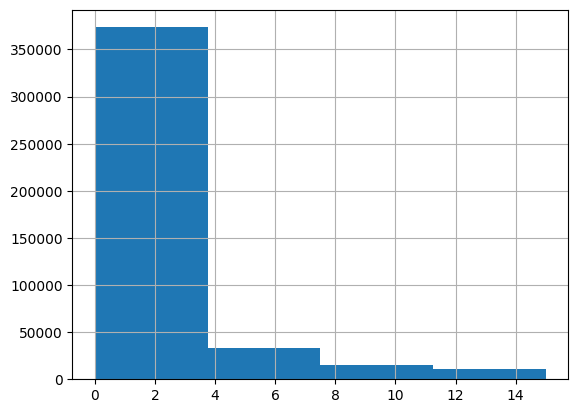

In [30]:
merge_def["coef_ventas"].hist(bins=4)